In [1]:
# facilitate imports from project root
import sys
sys.path.append("..")

In [2]:
from chase_rank.match import match_track, combine_data, get_section_analytics

In [3]:
import collections
from copy import copy
from datetime import timedelta

import gpxpy
import overpy
import geopy.distance
import numpy as np
from geopy.distance import Distance

import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
from shapely.geometry import LineString, Point
from shapely.ops import transform
from routingpy import Valhalla, convert, utils

In [4]:
TEST_TRACK_PATH = "../data/routes/test_track.gpx"

VALHALLA_CLIENT = Valhalla(base_url="http://127.0.0.1:8002")
OVERPASS_API = overpy.Overpass()

---
# Datei Laden

In [5]:
with open(TEST_TRACK_PATH) as file_pointer:
    gpx_content = gpxpy.parse(file_pointer)

gpx_data = []
gpx_geometry = []
for point in gpx_content.tracks[0].segments[0].points:
    gpx_geometry.append(Point(point.longitude, point.latitude))
    gpx_data.append({
        # clear tzinfo until it can be handled for the match query
        "time": point.time.replace(tzinfo=None),
        "elev": point.elevation,
        "longitude": point.longitude,
        "latitude": point.latitude
    })

gpx_frame = gpd.GeoDataFrame(
    gpx_data, geometry=gpx_geometry, crs="EPSG:4326").to_crs("EPSG:3857")
# search for splits in the trace bigger than 1s and label consecutive sections
gpx_frame["section"] = (gpx_frame["time"].diff() != pd.Timedelta("1 second")).cumsum()

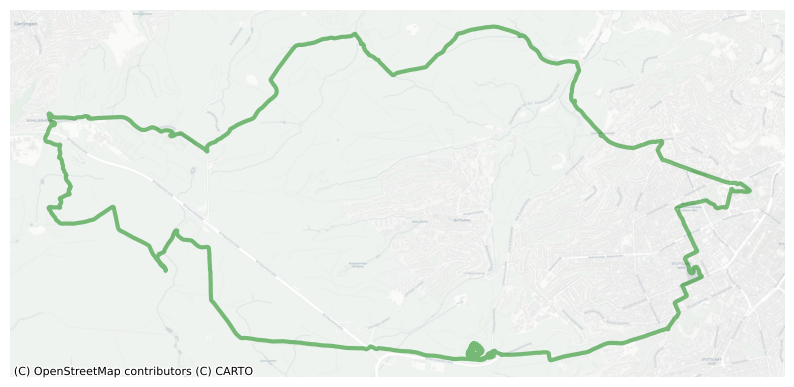

In [6]:
import contextily as cx

fig, ax = plt.subplots(1,1, figsize=(10,10))
gpd.GeoDataFrame(geometry=[LineString(gpx_frame["geometry"])]).plot(
    ax=ax, color="green", linewidth=3, alpha=0.5)
cx.add_basemap(ax=ax, crs="EPSG:3857", source=cx.providers.CartoDB.Positron)
_ = ax.axis("off")

---
# Matching

In [7]:
trace_df, edges_df = match_track(gpx_frame)

400 ({'error_code': 444, 'error': 'Map Match algorithm failed to find path: map_snap algorithm failed to snap the shape points to the correct shape.', 'status_code': 400, 'status': 'Bad Request'})
400 ({'error_code': 444, 'error': 'Map Match algorithm failed to find path: map_snap algorithm failed to snap the shape points to the correct shape.', 'status_code': 400, 'status': 'Bad Request'})
400 ({'error_code': 444, 'error': 'Map Match algorithm failed to find path: map_snap algorithm failed to snap the shape points to the correct shape.', 'status_code': 400, 'status': 'Bad Request'})


C:\Users\4rkla\PycharmProjects\chase-rank\venv\lib\site-packages\geopandas\array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 / Pseudo-Mercator (the single non-null crs provided).
  warnings.warn(


In [8]:
points_df = combine_data(gpx_frame, trace_df, edges_df)
points_df

C:\Users\4rkla\PycharmProjects\chase-rank\venv\lib\site-packages\geopandas\array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 / Pseudo-Mercator (the single non-null crs provided).
  warnings.warn(
C:\Users\4rkla\PycharmProjects\chase-rank\venv\lib\site-packages\geopandas\array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 / Pseudo-Mercator (the single non-null crs provided).
  warnings.warn(


,time,elev,longitude,latitude,geometry,section,surface,surface_section,use,osm_way_id,distance
0,2022-09-25 12:47:26,263.162771,9.162519,48.779777,POINT (1019966.949 6237576.435),1,paved_smooth,1,service_road,630532835.0,2.041398
1,2022-09-25 12:47:27,263.162771,9.162544,48.779785,POINT (1019969.732 6237577.787),1,paved_smooth,1,service_road,630532835.0,2.407625
2,2022-09-25 12:47:28,263.162771,9.162575,48.779792,POINT (1019973.183 6237578.969),1,paved_smooth,1,service_road,630532835.0,3.252079
3,2022-09-25 12:47:29,263.162771,9.162616,48.779803,POINT (1019977.747 6237580.828),1,paved_smooth,1,service_road,630532835.0,3.542168
4,2022-09-25 12:47:30,263.162771,9.162660,48.779816,POINT (1019982.646 6237583.024),1,paved_smooth,1,road,288879691.0,3.634560
...,...,...,...,...,...,...,...,...,...,...,...
5643,2022-09-25 14:43:12,263.345427,9.162525,48.779729,POINT (1019967.617 6237568.327),131,paved_smooth,389,service_road,266499727.0,0.576975
5644,2022-09-25 14:43:13,263.345427,9.162530,48.779733,POINT (1019968.174 6237569.002),131,paved_smooth,389,service_road,266499727.0,0.444659
5645,2022-09-25 14:43:14,263.345427,9.162534,48.779736,POINT (1019968.619 6237569.509),131,paved_smooth,389,service_road,266499727.0,0.073494
5646,2022-09-25 14:43:15,263.345427,9.162535,48.779736,POINT (1019968.731 6237569.509),131,paved_smooth,389,service_road,266499727.0,0.000000


In [9]:
section_analytics_df = get_section_analytics(points_df)
section_analytics_df

,section,paused_time,total_asc,total_desc,total_km,arg_kph,distance_between_stops
0,1,0 days 00:00:00,0.00,-11.31,611.00,20.18,8.972760
1,2,0 days 00:00:07,0.00,-4.32,416.83,19.24,5.582817
2,3,0 days 00:00:36,31.99,-0.23,1184.88,20.22,25.871729
3,4,0 days 00:00:30,0.19,0.00,2.92,2.10,0.000000
4,5,0 days 00:00:02,0.00,0.00,17.94,8.07,17.939770
...,...,...,...,...,...,...,...
127,128,0 days 00:00:08,3.81,-180.48,2900.02,30.89,5.421962
128,129,0 days 00:00:05,1.00,-5.70,778.22,25.24,7.438940
129,130,0 days 00:00:14,1.45,-0.06,347.94,21.97,1.853662
130,131,0 days 00:00:09,0.00,0.00,11.51,4.14,0.000000


In [13]:
surfaces = collections.defaultdict(lambda: 0.)# Distance(kilometers=0))
for index, surface_group in points_df.groupby("surface_section"):
    surface = surface_group["surface"].values[0]
    # distance = group["distance"].dropna(axis=0).sum()
    distance = surface_group["distance"].sum()
    surfaces[surface] += distance

# remove distances travelled during pauses
for index, section_group in points_df.groupby("section"):
    surface = section_group["surface"].values[-1]
    surfaces[surface] -= section_group["distance"].values[-1]

dict(surfaces)

{'paved_smooth': 11298.210103333928,
 'paved': 736.1845939756906,
 'compacted': 5229.940820478643,
 'gravel': 5951.444093789123,
 None: 762.1824955404869,
 'dirt': 779.1147436853224,
 'path': 779.5564762320649}

In [ ]:
map_ = gpx_frame[["geometry", "section"]][
    trace_df["geometry"].isnull()
].explore(name="gpx", color="green", style_kwds={"opacity": 0.5})
map_ = gpx_frame[["geometry", "section"]][
    trace_df["edge_index"].isnull()
].explore(m=map_, name="gpx", color="red", style_kwds={"opacity": 0.5, "fill": False})

map_